In [1]:
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.color
import skimage.filters
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

Franck's code: 
https://github.com/effepivi/ICE-3111-Computer_Vision/blob/main/Lectures/Week07-Segmentation/notebooks/4-segmentation-of-birds-python.ipynb

I used the first part which segments the birds and the island. The second part uses contours. Unfortunately, this approach did not work well on the images supplied later by Claire. I also did not use Franck's check for false positive based on gradients.

My approach is as follows:
1. Franck: Segment the image using a fixed threshold. (Franck determines the threshold by inspecting the histogram of the grey image.)
2. Franck: Find the island's mask.
3. Lucy: Use connected components to find the top and bottom edges of the island. Smooth the lines.
4. Find the birds' mask (Franck) using the smoothed island mask (Lucy).
5. Lucy: Use connected components to identify the birds.
6. Lucy: Check which birds are in feasible positions
   - (a) don't go beyond the horizontal span of the island 
   - (b) don't go under the top edge of the island
   - (c) don't too high above the top edge of the island (centroid up to 1.4 of the maximum height of a bird blob)
7. Lucy: I wrote a function `count_birds_penmon_roost3` which returns: number of birds, centroids of bird blobs, bounding boxes and sizes of the bird blobs, the bounding box of the island, and the top abd bottom edges of the island.

In addition, I have written a function `choose_threshold` to find a threshold automatically. The function calculates the histogram of the grey image, then smooths it, finds the highest peak and the lowest valley just before it. The assumption is that there are two peaks - one for the sea (lighter grey) and one for the island (darker grey). The largest peak should be the sea. 

In [2]:
def count_birds_penmon_roost3(colour_image, threshold = 65, morph_ellipse1 = 10, morph_ellipse2 = 30, morph_ellipse3 = 5):
    grey_image = cv2.cvtColor(colour_image, cv2.COLOR_RGB2GRAY)
    # grey_image = cv2.equalizeHist(grey_image) # This did not help because
    
    # Franck Vidal's code =================================================================================================
    segmented = cv2.threshold(grey_image,threshold, 255,cv2.THRESH_BINARY_INV)[1]

    # Find both island and birds
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_ellipse1, morph_ellipse1), (2, 2))
    island_and_birds_mask = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, element);
    island_and_birds_mask = cv2.morphologyEx(island_and_birds_mask, cv2.MORPH_OPEN, element);

    # Find island
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_ellipse2, morph_ellipse2),(2, 2))
    island_mask = cv2.morphologyEx(segmented, cv2.MORPH_OPEN, element);
    island_mask = cv2.morphologyEx(island_mask, cv2.MORPH_CLOSE, element);

    # Lucy's code ==========================================================================================================    
    nb_components_i, output_i, stats_i, centroids_i = cv2.connectedComponentsWithStats(island_mask, connectivity=8)
    # nb_components >>> number of components
    # output >>> image with labels
    # stats >>> [x,y,w,h,num_pixels]
    # centroids >>>

    # Find the component corresponding to the island - the second largest
    index_largest = np.argmax(stats_i[:,-1])
    stats_i[index_largest,-1] = 0 # mask the largest
    index_island = np.argmax(stats_i[:,-1])
    bb_island = stats_i[index_island,:]
    x,y,w,h,sz = bb_island
    # xisland = [x,x+w,x+w,x,x] # plotting coordinates for the island bounding box
    # yisland = [y,y,y+h,y+h,y]
 
    if w > 2000 & h < 1000: # Island exists
        island_bottom_edge = np.zeros(colour_image.shape[1])
        island_top_edge = np.zeros(colour_image.shape[1])
        for j in range(colour_image.shape[1]): 
            y_row = (output_i[:,j] == index_island)*1
            if np.sum(y_row) > 0:
                island_bottom_edge[j] = np.max(np.where(y_row))
                island_top_edge[j] = np.min(np.where(y_row))

        # Smooth the island's contour for better bird detection
        ind = island_bottom_edge > 0
        window_size = 321 # quite arbitrary
        if np.sum(ind) < window_size:
            window_size = np.floor(np.sum(ind)/4)*2+1 # magic        
        replacement = savgol_filter(island_bottom_edge[ind].ravel(), window_size, 2) 
        island_bottom_edge[ind] = replacement

        ind = island_top_edge > 0
        if np.sum(ind) < window_size:
            window_size = np.floor(np.sum(ind)/4)*2+1 # magic
        replacement = savgol_filter(island_top_edge[ind].ravel(), window_size, 2) 
        island_top_edge[ind] = replacement

        # Repair island's mask
        for j in range(colour_image.shape[1]): 
            y_row = (output_i[:,j] == index_island)*1
            if np.sum(y_row) > 0:
                island_mask[island_top_edge[j].astype(int):island_bottom_edge[j].astype(int),j] = 255

        # Franck Vidal's code ==============================================================================================
        # Find the birds 
        # -----------------------------------------------------------
        bird_mask = island_and_birds_mask - island_mask
        element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(morph_ellipse3, morph_ellipse3),(2, 2))
        bird_mask = cv2.erode(bird_mask, element, iterations = 3)

        # Lucy's code =====================================================================================================
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bird_mask, connectivity=8)

        # How many pixels is a bird? 
        mins = 8 # minimum size
        maxs = 2000 # maximum size

        # Choose birds only in the right positions and of the right size
        # --------------------------------------------------------------
        index = (stats[:,-1]>mins) & (stats[:,-1]<maxs) & (centroids[:,0]>x) & (centroids[:,0]<x+w)
        
        if sum(index) > 0:
            max_bird_height = np.max(stats[index,3])
            index_below_island_edge = np.zeros(nb_components)
            index_above_island_edge1 = np.zeros(nb_components)
            index_above_island_edge2 = np.zeros(nb_components)
            for j in range(nb_components): # find the mischiefs
                index_to_check = np.round(centroids[j,0]).astype(int)
                index_below_island_edge[j] = centroids[j,1] < island_bottom_edge[index_to_check]
                index_above_island_edge1[j] = centroids[j,1] > island_top_edge[index_to_check] - 1.4*max_bird_height
                index_above_island_edge2[j] = centroids[j,1] < island_top_edge[index_to_check] - 0.2*max_bird_height
                
            index = index &  (index_below_island_edge > 0) & (index_above_island_edge1 > 0) & (index_above_island_edge2 > 0) 

        nb = np.sum(index) # >>> number of birds
        island = np.vstack((island_bottom_edge,island_top_edge))
        return nb, centroids[index,:], stats[index,:], bb_island, island
    
    else: # Island does not exist
        nb = 0; centroids = []; stats = []; xisland = []; yisland = []; island = []
        return nb, centroids, stats, bb_island, island
    

In [3]:
def choose_threshold(im):
    # Choose a valley between the two modes of the histogram. The histogram is bimodal: "water" and "island"
    # Smoothing function: savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
    
    grey_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    histogram,_ = np.histogram(grey_image.ravel(),256,[0,256])
    
    histogram = savgol_filter(histogram.ravel(), 71, 3) # window size 51, polynomial order 3
    histogram = savgol_filter(histogram.ravel(), 71, 3) # window size 51, polynomial order 3
    peaks,stats = find_peaks(histogram.ravel(), height = 0.3)
    z = stats["peak_heights"]
    peak1 = np.argmax(z)
    valleys,_ = find_peaks(-histogram.ravel(), -z[peak1])
    vs = valleys[valleys<peaks[peak1]]
    
    
    plt.figure()
    plt.subplot(121)
    plt.plot(histogram,'k-') 
    plt.plot(peaks,histogram[peaks], 'ko')
    plt.plot(peaks[peak1],histogram[peaks[peak1]],'ro', mfc = "none", mew = 0.8, ms = 12)
    plt.title('Histogram')
    
    plt.subplot(122)
    plt.plot(-histogram)
    plt.plot(valleys,-histogram[valleys],'bo')
    thr = vs[-1]
    plt.plot(thr,-histogram[thr],'bo', mfc = "none", mew = 0.8, ms = 12)
    plt.title('Threshold =' + str(thr))
 
    return thr


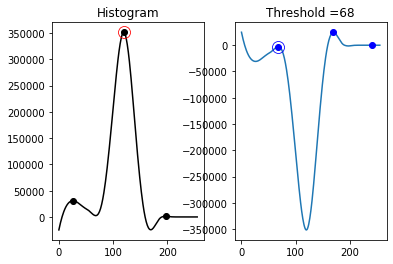

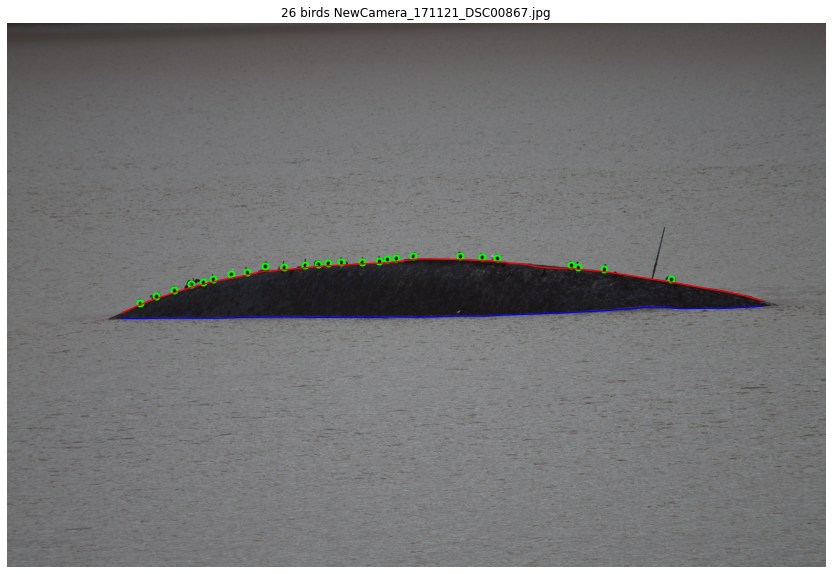

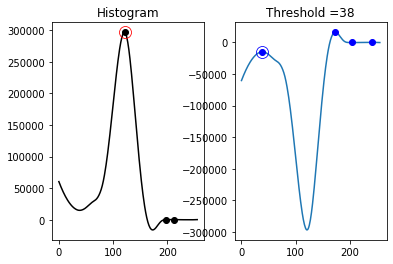

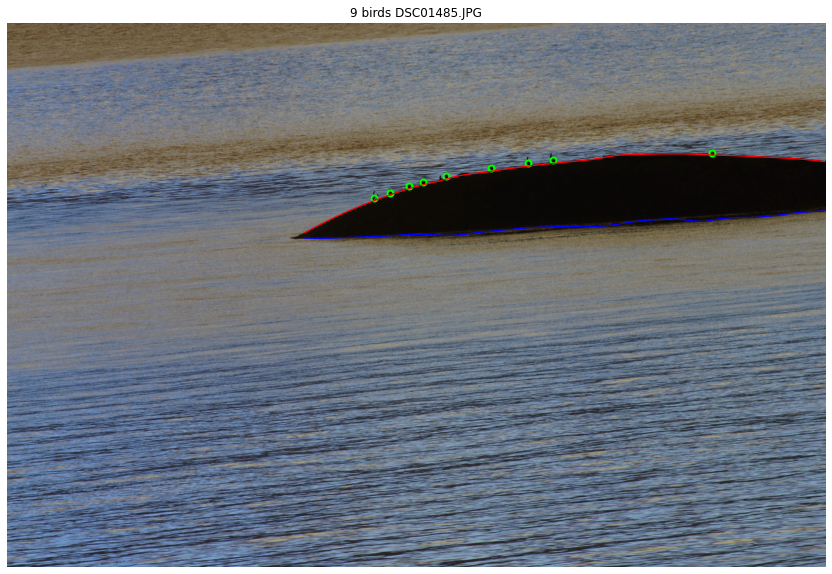

In [4]:
# The files are in folder 'PenmonRoostExamples/'. The resultant images are stored in folder 'PenmonRoostExamples/Results'

#files = ['NewCamera_171121_DSC00867.jpg','DSC01531.JPG', 'DSC01536.JPG', 'DSC01583.JPG', 'DSC01627.JPG', 'DSC01628.JPG',\
#         'DSC01266.JPG', 'DSC01307.JPG', 'DSC01309.JPG', 'DSC01312.JPG', 'DSC01343.JPG', 'DSC01345.JPG', 'DSC01359.JPG', \
#         'DSC01408.JPG', 'DSC01439.JPG', 'DSC01484.JPG', 'DSC01485.JPG']

files = ['NewCamera_171121_DSC00867.jpg', 'DSC01485.JPG']

flag_savefig = False

m = len(files)
numbers = np.zeros(m).astype(int)

for i in range(m):
    im = cv2.imread("PenmonRoostExamples/" + files[i], cv2.IMREAD_COLOR)
    t = choose_threshold(im) # 60
    numbers[i], centroids, _,bb_island,island = count_birds_penmon_roost3(im, threshold = t, \
            morph_ellipse1 = 10, morph_ellipse2 = 40,  morph_ellipse3 = 5)
    
    plt.figure(figsize=(20, 10))
    plt.imshow(im)
    plt.axis('Off')
    plt.title(str(numbers[i]) + " birds " + files[i])
    
    if numbers[i] > 0:
        plt.plot(centroids[:,0], centroids[:,1],'o', color = [0,1,0], mfc = "none", mew = 2, ms = 6)
        ind = np.array(np.where(island[0,:]>0))
        ind = ind[0]
        plt.plot(ind,island[0,ind],'b-',lw = 1.2)
        plt.plot(ind,island[1,ind],'r-',lw = 1.2)

    if flag_savefig:
        fn = "PenmonRoostExamples/Results/" + files[i]+ "_birds_" + str(numbers[i])  + '.jpg'
        plt.savefig(fn, dpi = 600)

    plt.show()
